In [1]:
# To work with data
import numpy as np
import pandas as pd
from scipy import stats
import re
# To parse missed information from additional sources
import requests
from bs4 import BeautifulSoup
import time


# To visualize information
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly as py
import networkx as nx



In [2]:
df = pd.read_csv('nba2k-full.csv')

df.head()

full_name  rating jersey                  team position  \
0           LeBron James      97    #23    Los Angeles Lakers        F   
1          Kawhi Leonard      97     #2  Los Angeles Clippers        F   
2  Giannis Antetokounmpo      96    #34       Milwaukee Bucks      F-G   
3           Kevin Durant      96     #7         Brooklyn Nets        F   
4           James Harden      96    #13       Houston Rockets        G   

      b_day       height                weight     salary country  draft_year  \
0  12/30/84   6-9 / 2.06  250 lbs. / 113.4 kg.  $37436858     USA        2003   
1  06/29/91   6-7 / 2.01  225 lbs. / 102.1 kg.  $32742000     USA        2011   
2  12/06/94  6-11 / 2.11  242 lbs. / 109.8 kg.  $25842697  Greece        2013   
3  09/29/88  6-10 / 2.08  230 lbs. / 104.3 kg.  $37199000     USA        2007   
4  08/26/89   6-5 / 1.96   220 lbs. / 99.8 kg.  $38199000     USA        2009   

  draft_round draft_peak          college  version  
0           1          1              NaN  NBA2k20  
1           1         15  San Diego State  NBA2k20  
2           1         15              NaN  NBA2k20  
3           1          2            Texas  NBA2k20  
4           1          3    Arizona State  NBA2k20

In [3]:
df.shape

(439, 15)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439 entries, 0 to 438
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   full_name    439 non-null    object
 1   rating       439 non-null    int64 
 2   jersey       439 non-null    object
 3   team         416 non-null    object
 4   position     439 non-null    object
 5   b_day        439 non-null    object
 6   height       439 non-null    object
 7   weight       439 non-null    object
 8   salary       439 non-null    object
 9   country      439 non-null    object
 10  draft_year   439 non-null    int64 
 11  draft_round  439 non-null    object
 12  draft_peak   439 non-null    object
 13  college      370 non-null    object
 14  version      439 non-null    object
dtypes: int64(2), object(13)
memory usage: 51.6+ KB


With the information given above, it can be seen that all columns are objects except "rating" and "draft_year". You can also see that the columns "team" and "college" have null values.

Now to clean the data, we first look for duplicates and null values

In [5]:
dup = df.duplicated().sum()

print(f'Number of duplicates - {dup}.')

Number of duplicates - 0.


We see that the method above returns no duplicates. However, let's specifically check for duplicates 

Let's try to find duplicates for an attribute that is unique to the player - full name.

In [6]:
name_dup = df['full_name'].duplicated().sum()

print(f'Number of duplicates - {name_dup}.')

Number of duplicates - 10.


10 duplicates were found. Let's check them.

In [7]:
df[df['full_name'].duplicated()]

full_name  rating jersey                    team position  \
429           LeBron James      97     #6      Los Angeles Lakers        F   
430  Giannis Antetokounmpo      97    #34         Milwaukee Bucks      F-G   
431          Kawhi Leonard      96     #2    Los Angeles Clippers        F   
432           James Harden      96    #13           Brooklyn Nets        G   
433          Stephen Curry      95    #30   Golden State Warriors        G   
434           Kevin Durant      95     #7           Brooklyn Nets        F   
435          Anthony Davis      95     #3      Los Angeles Lakers      F-C   
436            Luka Doncic      94    #77        Dallas Mavericks      G-F   
437         Damian Lillard      94     #0  Portland Trail Blazers        G   
438            Joel Embiid      91    #21      Philadelphia 76ers        C   

        b_day       height                weight     salary   country  \
429  12/30/84   6-9 / 2.06  250 lbs. / 113.4 kg.  $41180544       USA   
430  12/06/94  6-11 / 2.11  242 lbs. / 109.8 kg.  $39344900    Greece   
431  06/29/91   6-7 / 2.01  225 lbs. / 102.1 kg.  $39344900       USA   
432  08/26/89   6-5 / 1.96   220 lbs. / 99.8 kg.  $44310840       USA   
433  03/14/88   6-3 / 1.91   185 lbs. / 83.9 kg.  $45780966       USA   
434  09/29/88  6-10 / 2.08  230 lbs. / 104.3 kg.  $40918900       USA   
435  03/11/93  6-10 / 2.08  222 lbs. / 100.7 kg.  $35361360       USA   
436  02/28/99   6-7 / 2.01    227 lbs. / 103 kg.  $10174391  Slovenia   
437  07/15/90   6-2 / 1.88   195 lbs. / 88.5 kg.  $39344900       USA   
438  03/16/94   7-0 / 2.13  250 lbs. / 113.4 kg.  $31579390  Cameroon   

     draft_year draft_round draft_peak          college  version  
429        2003           1          1              NaN  NBA2k21  
430        2013           1         15              NaN  NBA2k21  
431        2011           1         15  San Diego State  NBA2k21  
432        2009           1          3    Arizona State  NBA2k21  
433        2009           1          7         Davidson  NBA2k21  
434        2007           1          2            Texas  NBA2k21  
435        2012           1          1         Kentucky  NBA2k21  
436        2018           1          3              NaN  NBA2k21  
437        2012           1          6      Weber State  NBA2k21  
438        2014           1          3           Kansas  NBA2k21

Checking the duplicates by full name only, it is clear to see that duplicates are caused by these players having information in NBA2k21 as well as NBA2k20. This is also why we received no duplicates when checking the data as a whole. Each column is technically different since the version is different. Now we check how many rows have NBA2k21 as a version

In [8]:
amount_of_21 = len(df[df['version'] == 'NBA2k21']['version'])

print(f'NBA2K21 players - {amount_of_21}.')

NBA2K21 players - 10.


We see that the number of duplicates coincides with the number of players in the NBA2K21 version. \
For more accurate conclusions, let's check the number of players in the NBA2K20 version.

In [9]:
amount_of_20 = len(df[df['version'] == 'NBA2k20']['version'])

print(f'NBA2K21 players- {amount_of_20}.')

NBA2K21 players- 429.


The duplicate data with the NBA2k21 version is an issue for our analysis, so these need to be removed.

In [10]:
df = df[df.version != "NBA2k21"]

In [11]:
dup = df['full_name'].duplicated().sum()
print(f'Available number of duplicates - {dup}.')

Available number of duplicates - 0.


Next, we take a look at the null values in the team column

In [12]:
df[df['team'].isna()]

full_name  rating jersey team position     b_day       height  \
33     DeMarcus Cousins      86     #0  NaN        C  08/13/90  6-10 / 2.08   
168     Michael Beasley      76     #0  NaN        F  01/09/89  6-10 / 2.08   
177        Gerald Green      76     #0  NaN      F-G  01/26/86   6-6 / 1.98   
198       Isaiah Thomas      76     #0  NaN        G  02/07/89   5-9 / 1.75   
203           Pau Gasol      75     #0  NaN        C  07/06/80   7-1 / 2.16   
237       Allonzo Trier      75     #0  NaN      G-F  01/17/96   6-4 / 1.93   
264    Chandler Parsons      74     #0  NaN        F  10/25/88   6-9 / 2.06   
266           Ivan Rabb      74     #0  NaN      F-C  02/04/97  6-10 / 2.08   
283        Allen Crabbe      73     #0  NaN      G-F  04/09/92   6-5 / 1.96   
294            CJ Miles      73     #0  NaN      G-F  03/18/87   6-6 / 1.98   
301    Jonathon Simmons      73     #0  NaN      G-F  09/14/89   6-6 / 1.98   
317    Antonio Blakeney      72     #0  NaN      G-F  10/04/96   6-4 / 1.93   
323         Tim Frazier      72     #0  NaN        G  11/01/90   6-0 / 1.83   
353         Chuma Okeke      72     #3  NaN      F-C  08/18/98   6-8 / 2.03   
362       Deyonta Davis      71     #0  NaN      F-C  12/02/96  6-10 / 2.08   
394         Tyler Lydon      70     #0  NaN      F-C  04/09/96   6-9 / 2.06   
398       Miles Plumlee      70     #0  NaN      F-C  09/01/88  6-11 / 2.11   
401      Jemerrio Jones      70     #0  NaN        F  04/09/95   6-5 / 1.96   
404         Yante Maten      70     #0  NaN      F-C  08/14/96   6-8 / 2.03   
410      Henry Ellenson      69     #0  NaN      F-C  01/13/97  6-10 / 2.08   
412     Amile Jefferson      69     #0  NaN      F-C  05/07/93   6-9 / 2.06   
418      Tyrone Wallace      69     #0  NaN      G-F  06/10/94   6-5 / 1.96   
422  Isaiah Hartenstein      68     #0  NaN      F-C  05/05/98   7-0 / 2.13   

                   weight     salary  country  draft_year draft_round  \
33   270 lbs. / 122.5 kg.   $3500000      USA        2010           1   
168  235 lbs. / 106.6 kg.   $3500000      USA        2008           1   
177   192 lbs. / 87.1 kg.   $2564753      USA        2005           1   
198   185 lbs. / 83.9 kg.   $2320044      USA        2011           2   
203  250 lbs. / 113.4 kg.   $5538540    Spain        2001           1   
237   200 lbs. / 90.7 kg.   $3551100      USA        2018   Undrafted   
264   200 lbs. / 90.7 kg.  $25102512      USA        2011           2   
266   220 lbs. / 99.8 kg.    $451326      USA        2017           2   
283   197 lbs. / 89.4 kg.  $17818456      USA        2013           2   
294  232 lbs. / 105.2 kg.   $8730158      USA        2005           2   
301   195 lbs. / 88.5 kg.   $1000000      USA        2012   Undrafted   
317   197 lbs. / 89.4 kg.   $1488231      USA        2017   Undrafted   
323   170 lbs. / 77.1 kg.   $1620564      USA        2014   Undrafted   
353    230 lbs. / 104 kg.   $2773550      USA        2019           1   
362  240 lbs. / 108.9 kg.    $250000      USA        2016           2   
394   220 lbs. / 99.8 kg.     $50000      USA        2017           1   
398  255 lbs. / 115.7 kg.  $12500000      USA        2012           1   
401   201 lbs. / 91.2 kg.    $195077      USA        2018   Undrafted   
404  240 lbs. / 108.9 kg.    $100000      USA        2018   Undrafted   
410  242 lbs. / 109.8 kg.     $79568      USA        2016           1   
412  224 lbs. / 101.6 kg.   $1529007      USA        2017   Undrafted   
418   200 lbs. / 90.7 kg.    $502491      USA        2016           2   
422  250 lbs. / 113.4 kg.   $1416852  Germany        2017           2   

    draft_peak           college  version  
33           5          Kentucky  NBA2k20  
168          2      Kansas State  NBA2k20  
177         18               NaN  NBA2k20  
198         60        Washington  NBA2k20  
203          3               NaN  NBA2k20  
237  Undrafted           Arizona  NBA2k20  
264         38           Florida  NBA2k20  
266         

Through research, we can see that these null values accompany players who(during the creation of this dataset) was not on a NBA team

For conclusive results, create a list of the names of all the players who have no information about their team.

In [13]:
list_of_players = df[df['team'].isna()]['full_name'].values.tolist()

print(list_of_players)

['DeMarcus Cousins', 'Michael Beasley', 'Gerald Green', 'Isaiah Thomas', 'Pau Gasol', 'Allonzo Trier', 'Chandler Parsons', 'Ivan Rabb', 'Allen Crabbe', 'CJ Miles', 'Jonathon Simmons', 'Antonio Blakeney', 'Tim Frazier', 'Chuma Okeke', 'Deyonta Davis', 'Tyler Lydon', 'Miles Plumlee', 'Jemerrio Jones', 'Yante Maten', 'Henry Ellenson', 'Amile Jefferson', 'Tyrone Wallace', 'Isaiah Hartenstein']


Transfer this list to an array and replace each whitespace with '_'

In [14]:
list_of_players_f = []

for player in list_of_players:
    full_name = player.split()
    full_name = full_name[0] + '_' + full_name[1]
    list_of_players_f.append(full_name)

print(list_of_players_f)

['DeMarcus_Cousins', 'Michael_Beasley', 'Gerald_Green', 'Isaiah_Thomas', 'Pau_Gasol', 'Allonzo_Trier', 'Chandler_Parsons', 'Ivan_Rabb', 'Allen_Crabbe', 'CJ_Miles', 'Jonathon_Simmons', 'Antonio_Blakeney', 'Tim_Frazier', 'Chuma_Okeke', 'Deyonta_Davis', 'Tyler_Lydon', 'Miles_Plumlee', 'Jemerrio_Jones', 'Yante_Maten', 'Henry_Ellenson', 'Amile_Jefferson', 'Tyrone_Wallace', 'Isaiah_Hartenstein']


Instead of dropping these players, the module Beautiful Soup allows me to parse through each player's wikipedia page to find the last team they were on professionally(Not only NBA). In order to prevent  the page from reloading with queries, I added a sleep timer of 1 second

In [15]:
url = 'https://en.wikipedia.org/wiki/'
list_teams = []

for full_name in list_of_players_f:
    link = url + full_name
    page = requests.get(link)
    time.sleep(1)
    
    soup = BeautifulSoup(page.text, "html.parser")

    try:
        list_teams.append(soup.findAll('td', class_="infobox-data")[-1].text)
    except:
        list_teams.append('-')

print(list_teams)

['Milwaukee Bucks', 'Cangrejeros de Santurce', 'Houston Rockets (player development)', '-', '3,925 (3.2 apg)', 'Iowa Wolves', 'Atlanta Hawks', 'Delaware Blue Coats', 'Minnesota Timberwolves', 'Boston Celtics', 'Shanxi Loongs', 'Canton Charge', 'Orlando Magic', 'Orlando Magic', 'Taoyuan Leopards', '→Capital City Go-Go', 'Perth Wildcats', 'Wisconsin Herd', 'Wonju DB Promy', 'Obradoiro', 'Galatasaray', 'Agua Caliente Clippers', 'Los Angeles Clippers']


We can see that this data needs to be cleaned up and some players do not have information regarding a team. Manually check these players and input the correct information.

In [16]:
list_teams[2] = list_teams[2][:15]
list_teams[3] = 'Dallas Mavericks'
list_teams[4] = 'FC Barcelona'
list_teams[15] = list_teams[15][1:]

Display the updated letter:

In [17]:
print(list_teams)

['Milwaukee Bucks', 'Cangrejeros de Santurce', 'Houston Rockets', 'Dallas Mavericks', 'FC Barcelona', 'Iowa Wolves', 'Atlanta Hawks', 'Delaware Blue Coats', 'Minnesota Timberwolves', 'Boston Celtics', 'Shanxi Loongs', 'Canton Charge', 'Orlando Magic', 'Orlando Magic', 'Taoyuan Leopards', 'Capital City Go-Go', 'Perth Wildcats', 'Wisconsin Herd', 'Wonju DB Promy', 'Obradoiro', 'Galatasaray', 'Agua Caliente Clippers', 'Los Angeles Clippers']


We can now add this data into our dataset

In [18]:
index = df[df['team'].isna()]['full_name'].index.values

list_new_team = []

n=0
for i, team in enumerate(df['team']):
    if i in index:
        list_new_team.append(list_teams[n])
        n += 1
    else:
        list_new_team.append(team)

col_team = pd.DataFrame(list_new_team, columns=['team'])
df['team'] = col_team

df.iloc[index] 

full_name  rating jersey                     team position  \
33     DeMarcus Cousins      86     #0          Milwaukee Bucks        C   
168     Michael Beasley      76     #0  Cangrejeros de Santurce        F   
177        Gerald Green      76     #0          Houston Rockets      F-G   
198       Isaiah Thomas      76     #0         Dallas Mavericks        G   
203           Pau Gasol      75     #0             FC Barcelona        C   
237       Allonzo Trier      75     #0              Iowa Wolves      G-F   
264    Chandler Parsons      74     #0            Atlanta Hawks        F   
266           Ivan Rabb      74     #0      Delaware Blue Coats      F-C   
283        Allen Crabbe      73     #0   Minnesota Timberwolves      G-F   
294            CJ Miles      73     #0           Boston Celtics      G-F   
301    Jonathon Simmons      73     #0            Shanxi Loongs      G-F   
317    Antonio Blakeney      72     #0            Canton Charge      G-F   
323         Tim Frazier      72     #0            Orlando Magic        G   
353         Chuma Okeke      72     #3            Orlando Magic      F-C   
362       Deyonta Davis      71     #0         Taoyuan Leopards      F-C   
394         Tyler Lydon      70     #0       Capital City Go-Go      F-C   
398       Miles Plumlee      70     #0           Perth Wildcats      F-C   
401      Jemerrio Jones      70     #0           Wisconsin Herd        F   
404         Yante Maten      70     #0           Wonju DB Promy      F-C   
410      Henry Ellenson      69     #0                Obradoiro      F-C   
412     Amile Jefferson      69     #0              Galatasaray      F-C   
418      Tyrone Wallace      69     #0   Agua Caliente Clippers      G-F   
422  Isaiah Hartenstein      68     #0     Los Angeles Clippers      F-C   

        b_day       height                weight     salary  country  \
33   08/13/90  6-10 / 2.08  270 lbs. / 122.5 kg.   $3500000      USA   
168  01/09/89  6-10 / 2.08  235 lbs. / 106.6 kg.   $3500000      USA   
177  01/26/86   6-6 / 1.98   192 lbs. / 87.1 kg.   $2564753      USA   
198  02/07/89   5-9 / 1.75   185 lbs. / 83.9 kg.   $2320044      USA   
203  07/06/80   7-1 / 2.16  250 lbs. / 113.4 kg.   $5538540    Spain   
237  01/17/96   6-4 / 1.93   200 lbs. / 90.7 kg.   $3551100      USA   
264  10/25/88   6-9 / 2.06   200 lbs. / 90.7 kg.  $25102512      USA   
266  02/04/97  6-10 / 2.08   220 lbs. / 99.8 kg.    $451326      USA   
283  04/09/92   6-5 / 1.96   197 lbs. / 89.4 kg.  $17818456      USA   
294  03/18/87   6-6 / 1.98  232 lbs. / 105.2 kg.   $8730158      USA   
301  09/14/89   6-6 / 1.98   195 lbs. / 88.5 kg.   $1000000      USA   
317  10/04/96   6-4 / 1.93   197 lbs. / 89.4 kg.   $1488231      USA   
323  11/01/90   6-0 / 1.83   170 lbs. / 77.1 kg.   $1620564      USA   
353  08/18/98   6-8 / 2.03    230 lbs. / 104 kg.   $2773550      USA   
362  12/02/96  6-10 / 2.08  240 lbs. / 108.9 kg.    $250000      USA   
394  04/09/96   6-9 / 2.06   220 lbs. / 99.8 kg.     $50000      USA   
398  09/01/88  6-11 / 2.11  255 lbs. / 115.7 kg.  $12500000      USA   
401  04/09/95   6-5 / 1.96   201 lbs. / 91.2 kg.    $195077      USA   
404  08/14/96   6-8 / 2.03  240 lbs. / 108.9 kg.    $100000      USA   
410  01/13/97  6-10 / 2.08  242 lbs. / 109.8 kg.     $79568      USA   
412  05/07/93   6-9 / 2.06  224 lbs. / 101.6 kg.   $1529007      USA   
418  06/10/94   6-5 / 1.96   200 lbs. / 90.7 kg.    $502491      USA   
422  05/05/98   7-0 / 2.13  250 lbs. / 113.4 kg.   $1416852  Germany   

     draft_year draft_round draft_peak           college  version  
33         2010           1          5          Kentucky  NBA2k20  
168        2008           1          2      Kansas State  NBA2k20  
177        2005           1         18               NaN  NBA2k20  
198        2011           2         60        Washington  NBA2k20  
203        2001           1          3               NaN  NBA2k20  
237        2018   Undrafted  Undrafted           Ari

We also need to fill in the data for their latest respective jersey numbers. We can do the same thing, however wikipedia does not always offer information regarding jersey numbers so we use a different website

In [19]:
 list_numbers = []

for full_name in list_of_players_f:
     full_name = full_name.lower()
     url = f'https://www.landofbasketball.com/nba_players/{full_name}.htm'
   # print(full_name)
     page = requests.get(url)
     time.sleep(1)

     soup = BeautifulSoup(page.text, "html.parser")

     for i in range(1, 3):
         s = soup.findAll('tr', class_="a-top")[i].findAll('td')[1].text
         res = [int(n) for n in s.split() if n.isdigit()]
        
         try:
             res[-1] 
        
         except:
             continue
        
         if type(res[-1]) == int:
             list_numbers.append(f"#{res[-1]}")
             break
         continue
        
print(list_numbers)

['#15', '#11', '#14', '#17', '#14', '#31', '#10', '#9', '#50', '#14', '#9', '#8', '#3', '#4', '#20', '#18', '#0', '#44', '#11', '#8']


It seems that some players were skipped as they may have not had sufficient information in the site. Manually check to ensure each jersey number is correct, if wrong, manually change 

In [20]:
list_numbers = ['#15', '#11', '#14', '#2', '#16', '#14', '#34', '#4', '#9', '#34', '#14', '#9', '#8', '#3', '#4', '#20', '#18', '#10', '#0', '#8', '#11', '#8', '#55']

In [21]:

list_new_numbers = []

n=0
for i, jersey in enumerate(df['jersey']):
    if i in index:
        list_new_numbers.append(list_numbers[n])
        n += 1
    else:
        list_new_numbers.append(jersey)

df['jersey'] = pd.DataFrame(list_new_numbers, columns=['jersey'])


df.iloc[index] 

full_name  rating jersey                     team position  \
33     DeMarcus Cousins      86    #15          Milwaukee Bucks        C   
168     Michael Beasley      76    #11  Cangrejeros de Santurce        F   
177        Gerald Green      76    #14          Houston Rockets      F-G   
198       Isaiah Thomas      76     #2         Dallas Mavericks        G   
203           Pau Gasol      75    #16             FC Barcelona        C   
237       Allonzo Trier      75    #14              Iowa Wolves      G-F   
264    Chandler Parsons      74    #34            Atlanta Hawks        F   
266           Ivan Rabb      74     #4      Delaware Blue Coats      F-C   
283        Allen Crabbe      73     #9   Minnesota Timberwolves      G-F   
294            CJ Miles      73    #34           Boston Celtics      G-F   
301    Jonathon Simmons      73    #14            Shanxi Loongs      G-F   
317    Antonio Blakeney      72     #9            Canton Charge      G-F   
323         Tim Frazier      72     #8            Orlando Magic        G   
353         Chuma Okeke      72     #3            Orlando Magic      F-C   
362       Deyonta Davis      71     #4         Taoyuan Leopards      F-C   
394         Tyler Lydon      70    #20       Capital City Go-Go      F-C   
398       Miles Plumlee      70    #18           Perth Wildcats      F-C   
401      Jemerrio Jones      70    #10           Wisconsin Herd        F   
404         Yante Maten      70     #0           Wonju DB Promy      F-C   
410      Henry Ellenson      69     #8                Obradoiro      F-C   
412     Amile Jefferson      69    #11              Galatasaray      F-C   
418      Tyrone Wallace      69     #8   Agua Caliente Clippers      G-F   
422  Isaiah Hartenstein      68    #55     Los Angeles Clippers      F-C   

        b_day       height                weight     salary  country  \
33   08/13/90  6-10 / 2.08  270 lbs. / 122.5 kg.   $3500000      USA   
168  01/09/89  6-10 / 2.08  235 lbs. / 106.6 kg.   $3500000      USA   
177  01/26/86   6-6 / 1.98   192 lbs. / 87.1 kg.   $2564753      USA   
198  02/07/89   5-9 / 1.75   185 lbs. / 83.9 kg.   $2320044      USA   
203  07/06/80   7-1 / 2.16  250 lbs. / 113.4 kg.   $5538540    Spain   
237  01/17/96   6-4 / 1.93   200 lbs. / 90.7 kg.   $3551100      USA   
264  10/25/88   6-9 / 2.06   200 lbs. / 90.7 kg.  $25102512      USA   
266  02/04/97  6-10 / 2.08   220 lbs. / 99.8 kg.    $451326      USA   
283  04/09/92   6-5 / 1.96   197 lbs. / 89.4 kg.  $17818456      USA   
294  03/18/87   6-6 / 1.98  232 lbs. / 105.2 kg.   $8730158      USA   
301  09/14/89   6-6 / 1.98   195 lbs. / 88.5 kg.   $1000000      USA   
317  10/04/96   6-4 / 1.93   197 lbs. / 89.4 kg.   $1488231      USA   
323  11/01/90   6-0 / 1.83   170 lbs. / 77.1 kg.   $1620564      USA   
353  08/18/98   6-8 / 2.03    230 lbs. / 104 kg.   $2773550      USA   
362  12/02/96  6-10 / 2.08  240 lbs. / 108.9 kg.    $250000      USA   
394  04/09/96   6-9 / 2.06   220 lbs. / 99.8 kg.     $50000      USA   
398  09/01/88  6-11 / 2.11  255 lbs. / 115.7 kg.  $12500000      USA   
401  04/09/95   6-5 / 1.96   201 lbs. / 91.2 kg.    $195077      USA   
404  08/14/96   6-8 / 2.03  240 lbs. / 108.9 kg.    $100000      USA   
410  01/13/97  6-10 / 2.08  242 lbs. / 109.8 kg.     $79568      USA   
412  05/07/93   6-9 / 2.06  224 lbs. / 101.6 kg.   $1529007      USA   
418  06/10/94   6-5 / 1.96   200 lbs. / 90.7 kg.    $502491      USA   
422  05/05/98   7-0 / 2.13  250 lbs. / 113.4 kg.   $1416852  Germany   

     draft_year draft_round draft_peak           college  version  
33         2010           1          5          Kentucky  NBA2k20  
168        2008           1          2      Kansas State  NBA2k20  
177        2005           1         18               NaN  NBA2k20  
198        2011           2         60        Washington  NBA2k20  
203        2001           1          3               NaN  NBA2k20  
237        2018   Undrafted  Undrafted           Ari

There is still some missing information, particularly in the college section. Obviously, not all players went to college but we should not leave the data as "NaN".

In [22]:
df['college'] = df['college'].apply(lambda item: 'Did not attend' if item is np.nan else item)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 429 entries, 0 to 428
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   full_name    429 non-null    object
 1   rating       429 non-null    int64 
 2   jersey       429 non-null    object
 3   team         429 non-null    object
 4   position     429 non-null    object
 5   b_day        429 non-null    object
 6   height       429 non-null    object
 7   weight       429 non-null    object
 8   salary       429 non-null    object
 9   country      429 non-null    object
 10  draft_year   429 non-null    int64 
 11  draft_round  429 non-null    object
 12  draft_peak   429 non-null    object
 13  college      429 non-null    object
 14  version      429 non-null    object
dtypes: int64(2), object(13)
memory usage: 53.6+ KB


Now we clean up the rest of the data by changing data types, stripping symbols, etc

In [24]:
#Change jersey column type to int and change birthday column to display age of player
df['jersey'] = df['jersey'].apply(lambda item: np.int64(item[1:]))

df['age'] = df['b_day'].apply(lambda item: 2021 - int('19' + item[-2:]) if int(item[-2:]) > 50 else 2021 - int('20' + item[-2:]))
df = df.drop(columns=['b_day'])

In [25]:
#Height and weight are measured two ways, we choose one way(meters, kg) and convert it to a numerical value
df['height'] = df['height'].apply(lambda item: float(item.split('/')[1]))

df['weight'] = df['weight'].apply(lambda item: float(re.search(r'\d*.\d*', item.split('/')[1].strip())[0]))

In [26]:
#Strip $ from salary values and convert the values to int
df['salary'] = df['salary'].map(lambda x: x.lstrip('$'))
df['salary']=df['salary'].astype('int64')

In [27]:
df['draft_round'] = df['draft_round'].apply(lambda item: 0 if item == 'Undrafted' else np.int64(item))

df['draft_peak'] = df['draft_peak'].apply(lambda item: 0 if item == 'Undrafted' else np.int64(item))

We check if everything is done correctly.

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 429 entries, 0 to 428
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   full_name    429 non-null    object 
 1   rating       429 non-null    int64  
 2   jersey       429 non-null    int64  
 3   team         429 non-null    object 
 4   position     429 non-null    object 
 5   height       429 non-null    float64
 6   weight       429 non-null    float64
 7   salary       429 non-null    int64  
 8   country      429 non-null    object 
 9   draft_year   429 non-null    int64  
 10  draft_round  429 non-null    int64  
 11  draft_peak   429 non-null    int64  
 12  college      429 non-null    object 
 13  version      429 non-null    object 
 14  age          429 non-null    int64  
dtypes: float64(2), int64(7), object(6)
memory usage: 53.6+ KB


In [29]:
df.loc[df['draft_round'] == 0]

full_name  rating  jersey                  team position  \
81       Robert Covington      80      33       Houston Rockets        F   
101            Joe Ingles      79       2             Utah Jazz        F   
109         Fred VanVleet      79      23       Toronto Raptors        G   
121        JaMychal Green      78       4  Los Angeles Clippers        F   
167       Jose Juan Barea      76       5      Dallas Mavericks        G   
..                    ...     ...     ...                   ...      ...   
420        Malcolm Miller      69      13       Toronto Raptors        F   
424       Brandon Goodwin      68       0         Atlanta Hawks        G   
426  Kostas Antetokounmpo      68      37    Los Angeles Lakers        F   
427          Jalen Lecque      68       0          Phoenix Suns        G   
428       Duncan Robinson      67      55            Miami Heat        F   

     height  weight    salary      country  draft_year  draft_round  \
81     2.01    94.8  11301219          USA        2013            0   
101    2.01    94.8  11454546    Australia        2009            0   
109    1.85    89.4   9346153          USA        2006            0   
121    2.03    99.8   4767000          USA        2012            0   
167    1.78    79.4   2564753  Puerto Rico        2006            0   
..      ...     ...       ...          ...         ...          ...   
420    2.01    93.0   1588231          USA        2015            0   
424    1.83    81.6    522738          USA        2018            0   
426    2.08    90.7     79568       Greece        2018            0   
427    1.91    86.2    898310          USA        2019            0   
428    2.01    97.5   1416852          USA        2018            0   

     draft_peak             college  version  age  
81            0     Tennessee State  NBA2k20   31  
101           0      Did not attend  NBA2k20   34  
109           0       Wichita State  NBA2k20   27  
121           0             Alabama  NBA2k20   31  
167           0        Northeastern  NBA2k20   37  
..          ...                 ...      ...  ...  
420           0          Holy Cross  NBA2k20   28  
424           0  Florida Gulf Coast  NBA2k20   26  
426           0              Dayton  NBA2k20   24  
427           0      Did not attend  NBA2k20   21  
428           0            Michigan  NBA2k20   27  

[67 rows x 15 columns]

If draft round and draft_peak = 0, this means the player was undrafted

We display the first 5 lines for visual inspection.

In [30]:
df.head()

full_name  rating  jersey                  team position  \
0           LeBron James      97      23    Los Angeles Lakers        F   
1          Kawhi Leonard      97       2  Los Angeles Clippers        F   
2  Giannis Antetokounmpo      96      34       Milwaukee Bucks      F-G   
3           Kevin Durant      96       7         Brooklyn Nets        F   
4           James Harden      96      13       Houston Rockets        G   

   height  weight    salary country  draft_year  draft_round  draft_peak  \
0    2.06   113.4  37436858     USA        2003            1           1   
1    2.01   102.1  32742000     USA        2011            1          15   
2    2.11   109.8  25842697  Greece        2013            1          15   
3    2.08   104.3  37199000     USA        2007            1           2   
4    1.96    99.8  38199000     USA        2009            1           3   

           college  version  age  
0   Did not attend  NBA2k20   37  
1  San Diego State  NBA2k20   30  
2   Did not attend  NBA2k20   27  
3            Texas  NBA2k20   33  
4    Arizona State  NBA2k20   32

Now the set is ready for analysis.

## Analysis of individual attributes

First, let's make descriptive statistics of individual attributes. \
We will deduce the table with descriptive values for each attribute.

In [31]:
df.describe(include='all')

full_name      rating      jersey             team position  \
count              429  429.000000  429.000000              429      429   
unique             429         NaN         NaN               44        7   
top     Darius Garland         NaN         NaN  Milwaukee Bucks        G   
freq                 1         NaN         NaN               18      169   
mean               NaN   76.372960   15.368298              NaN      NaN   
std                NaN    5.657748   16.037034              NaN      NaN   
min                NaN   67.000000    0.000000              NaN      NaN   
25%                NaN   72.000000    4.000000              NaN      NaN   
50%                NaN   75.000000   11.000000              NaN      NaN   
75%                NaN   79.000000   22.000000              NaN      NaN   
max                NaN   97.000000   99.000000              NaN      NaN   

            height      weight        salary country   draft_year  \
count   429.000000  429.000000  4.290000e+02     429   429.000000   
unique         NaN         NaN           NaN      39          NaN   
top            NaN         NaN           NaN     USA          NaN   
freq           NaN         NaN           NaN     323          NaN   
mean      1.995641   97.219814  8.530080e+06     NaN  2014.093240   
std       0.083514   10.536428  9.218059e+06     NaN     3.937678   
min       1.750000   77.100000  5.000000e+04     NaN  2001.000000   
25%       1.930000   89.400000  2.000000e+06     NaN  2012.000000   
50%       2.010000   96.600000  4.380120e+06     NaN  2015.000000   
75%       2.060000  104.300000  1.220000e+07     NaN  2017.000000   
max       2.240000  131.500000  4.023176e+07     NaN  2019.000000   

        draft_round  draft_peak         college  version         age  
count    429.000000  429.000000             429      429  429.000000  
unique          NaN         NaN             110        1         NaN  
top             NaN         NaN  Did not attend  NBA2k20         NaN  
freq            NaN         NaN              66      429         NaN  
mean       1.088578   18.207459             NaN      NaN   27.825175  
std        0.627698   16.051795             NaN      NaN    4.115133  
min        0.000000    0.000000             NaN      NaN   21.000000  
25%        1.000000    4.000000             NaN      NaN   25.000000  
50%        1.000000   14.000000             NaN      NaN   27.000000  
75%        1.000000   30.000000             NaN      NaN   31.000000  
max        2.000000   60.000000             NaN      NaN   41.000000

Let's examine each attribute

### Rating

There is no need to examine the 'full_name' column as it is clear that each name is unique to the player. Due to this fact, we move onto rating.
Rating is a special composite ratio that characterizes the player. The higher the rating, the better. We see that the maximum value is 97 and the minimum is 67. Let's examine further.

In [32]:
#Create a function to build a histogram
def build_hist(column):
    fig = px.histogram(df, x=column)
    fig.update_layout(title = f"{column.title()} of players", width=600, height=400)
    fig.show()

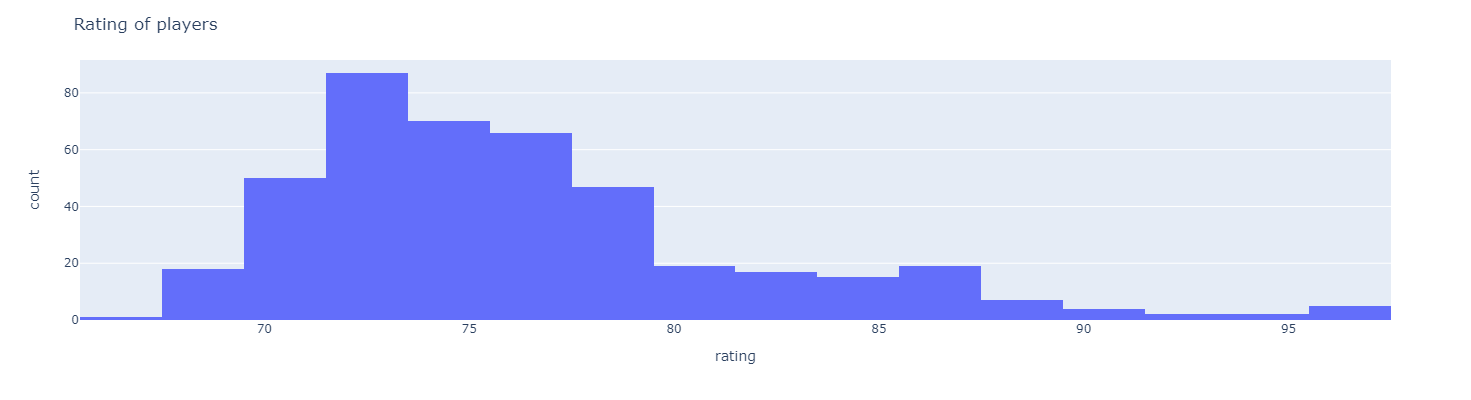

In [33]:
build_hist("rating")

Look at that the distribution is asymmetric with a long tail on the right. Let's test for normality.

In [34]:
def test_on_norm(column):
    alpha = 1e-3
    norm_res = stats.normaltest(column)
    print(f'p-value:{norm_res[1]}.')
    if norm_res[1] < alpha:
        print("The null hypothesis can be rejected")
    else:
        print("The null hypothesis cannot be rejected")

In [35]:
test_on_norm(df['rating'])

p-value:2.765343652076367e-19.
The null hypothesis can be rejected


The calculation above means that among the population, some rating values are more common than others. In this case - a lower rating value.

### Jersey

Next we will look at the distribution of player numbers in this population. To do this, build a histogram again.

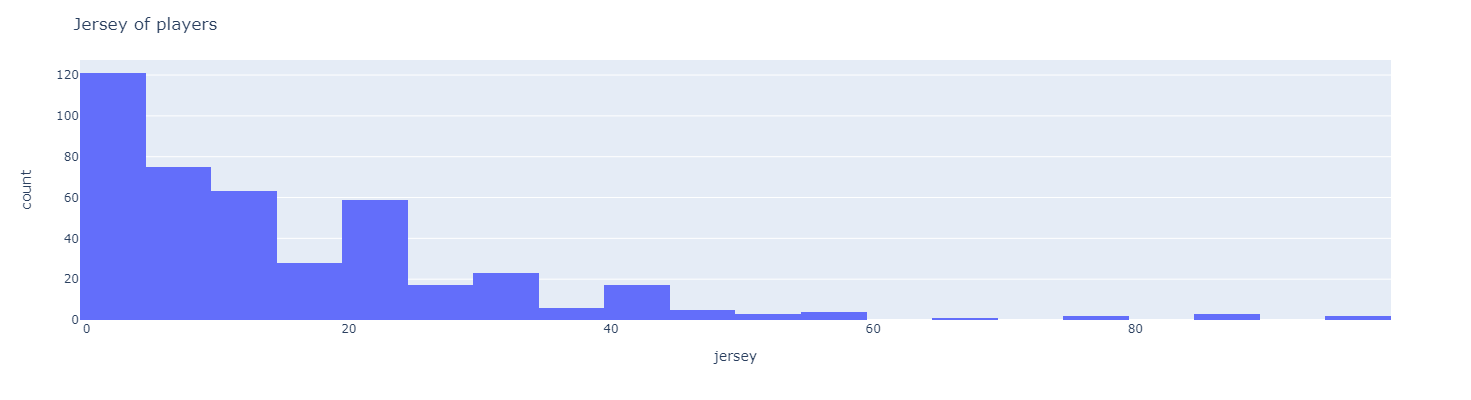

In [36]:
build_hist("jersey")

A similar situation to the player rankings. The distribution of numbers is not uniform and more common numbers are less than 60. \
Let us confirm our hypothesis statistically.

In [37]:
test_on_norm(df['jersey'])

p-value:1.6319177952964015e-42.
The null hypothesis can be rejected


The hypothesis is confirmed.

### Team

Since the value of this column is a categorical indicator, we will use a horizontal bar plot to analyze.

In [38]:
def build_bar(column):
    unique_names = df[column].unique()
    freq = []
    
    for name in unique_names:
        amount = (df[column] == name).sum()
        freq.append(amount)
    
    fig = px.bar()
    
    for name, amount in zip(unique_names, freq):
        fig.add_bar(y=[name], x=[amount], name=name, orientation='h')
        fig.update_layout(
            title = column.title()
            ,xaxis_title = 'Amount'
            ,yaxis_title = column
            ,width = 800
            ,height = 500
        )
    fig.show()
    
    return freq

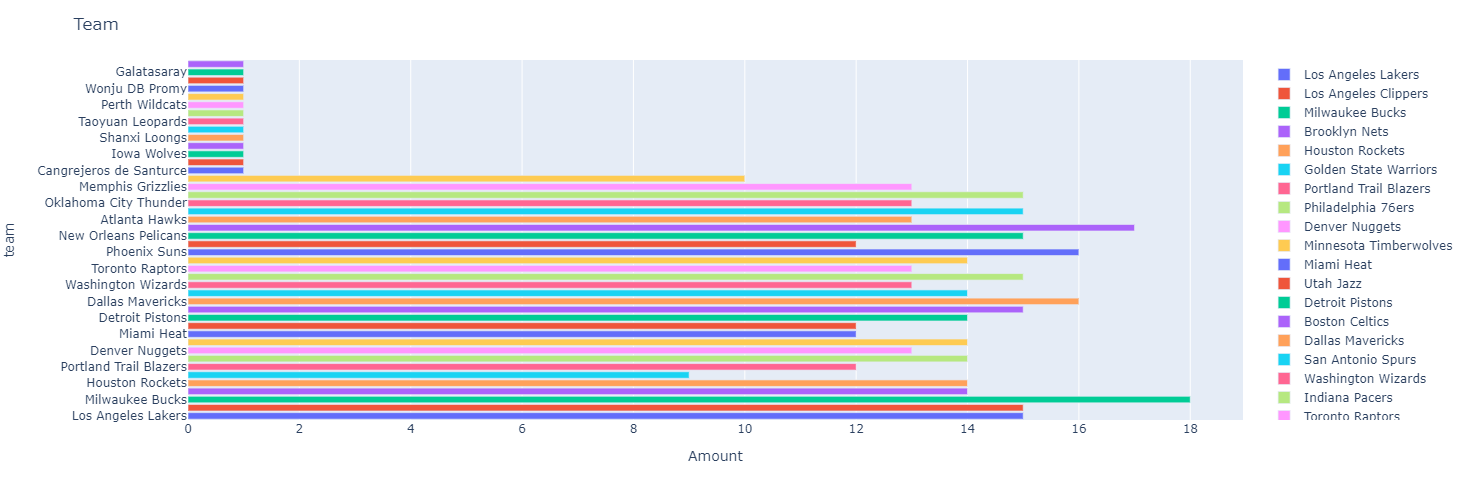

In [39]:
freq = build_bar('team')

Although many teams have around similar numbers, there is clearly some teams that are not represented as much as shown at the top of the graph

In [40]:
norm_res = stats.normaltest(freq)
print(f'p-value: {norm_res[1]}.')

p-value: 2.495534851702932e-06.


### Position

Let's build a bar plot to visualize the distribution of positions.

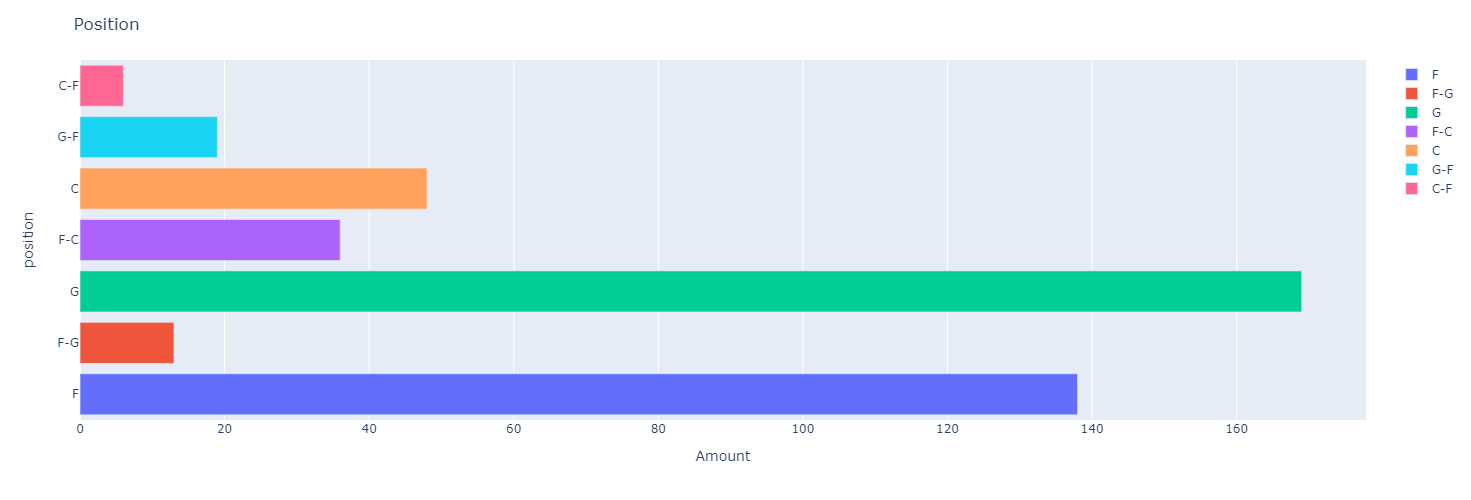

In [41]:
freq = build_bar('position')

The graph shows that the Guard position('G') is far more popular than other positions

Using previous results, we can clearly reject the hypothesis 

### Height

We build a histogram of the distribution of height among basketball players.

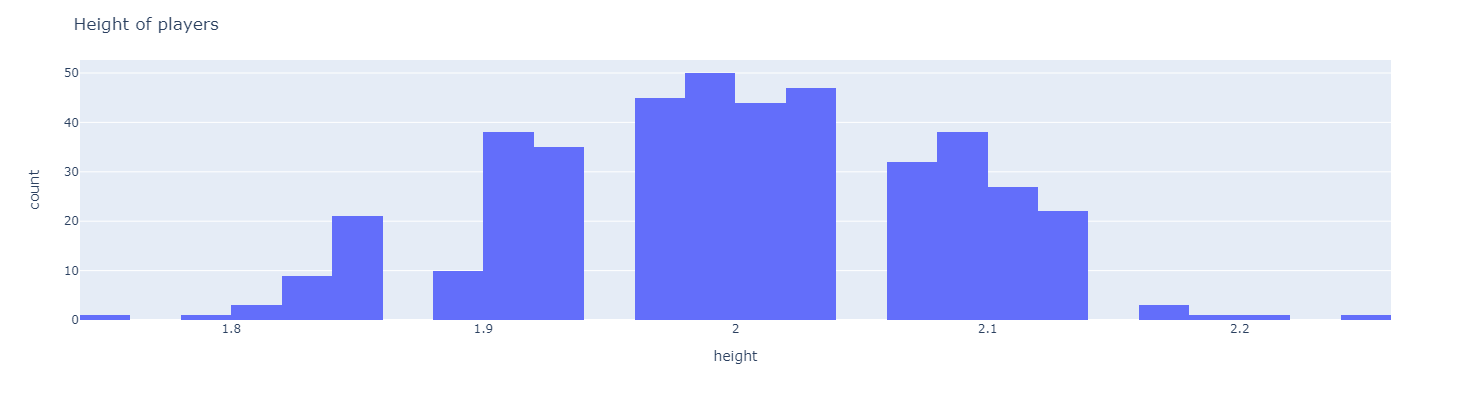

In [42]:
build_hist("height")

Visually, we can say that the distribution of growth is similar to normal. \
Let's run a test.

In [43]:
test_on_norm(df['height'])

p-value:0.08864738596500196.
The null hypothesis cannot be rejected


### Weight

We build a histogram of the distribution of weight among basketball players.

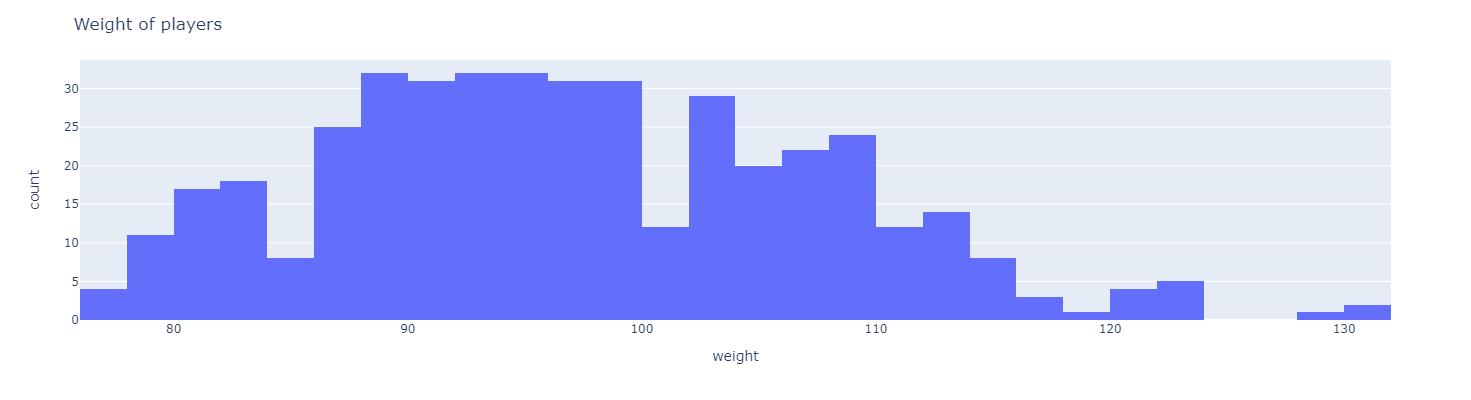

In [44]:
build_hist("weight")

In [45]:
test_on_norm(df['weight'])

p-value:0.004419588101514321.
The null hypothesis cannot be rejected


### Salary

Build a similar distribution for salary

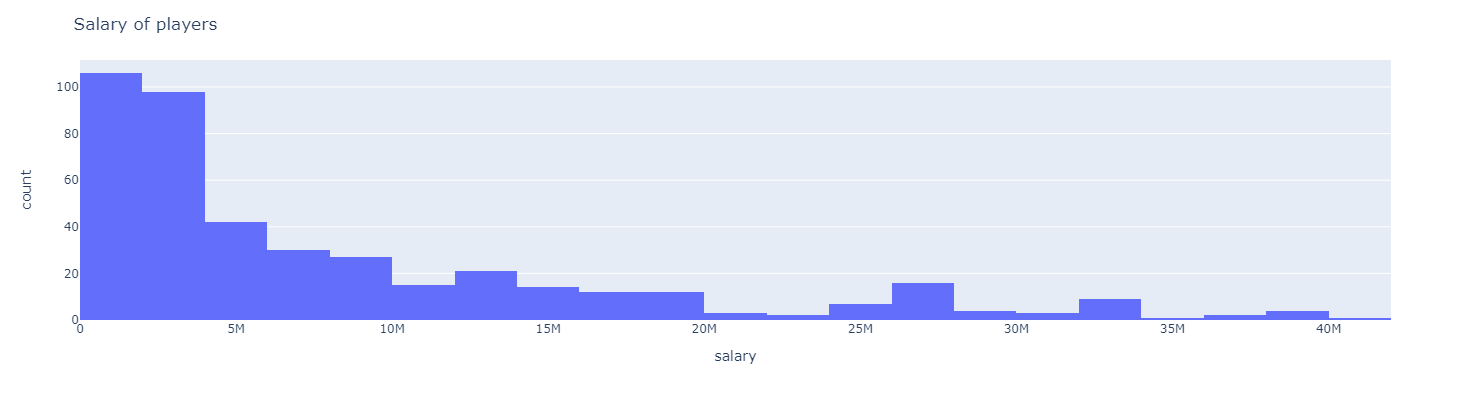

In [46]:
build_hist('salary')

According to this graph, we can conclude that the distribution is asymmetric with a long right tail. 
If we look at this graph and compare it with the graph of the ratings of the players, it can be seen that there is a possible correlation between the salary of a player and their overrall rating. This correlation will be explored further later on in our analyses

In [47]:
test_on_norm(df['salary'])

p-value:2.9578135519485964e-25.
The null hypothesis can be rejected


### Country

Let's see which countries are represented in this sample.

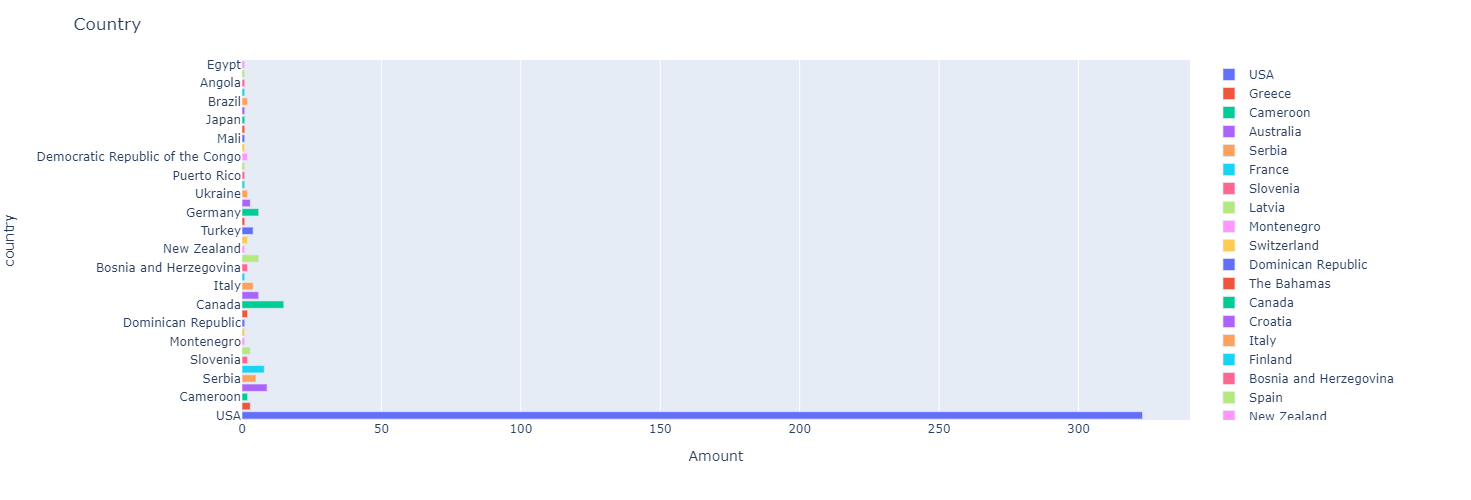

In [48]:
freq = build_bar('country')

You can clearly see a very strong asymmetrical relationship among which countries the players are from. Most players are from the USA (323). This is actually not a surprising statistic as the NBA began as an American league and began accepting international players much later in it's life.

In [49]:
norm_res = stats.normaltest(freq)
print(f'p-value: {norm_res[1]}.')

p-value: 2.957364838372805e-20.


The test confirms the asymmetry.

For a better visual representation of the data, let us create a map representing each country a player is from

In [50]:
countries = df['country'].unique().tolist()
amount = []

for country in countries:
    n = df[df['country'] == country].shape[0]
    amount.append(n)

data = dict(type='choropleth', locations=countries, locationmode='country names',z=amount)

map=go.Figure(data=data)
py.offline.plot(map)

'temp-plot.html'

### Age

Now we examine the data given for the age of the players. Before drawing the distribution, it is known that professional athletes will be relatively young

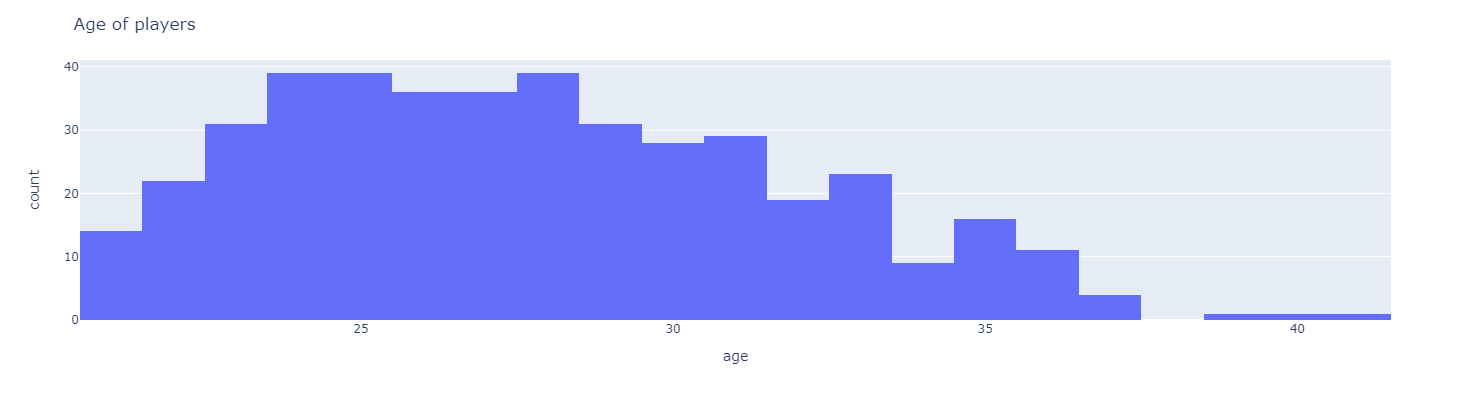

In [51]:
build_hist('age')

The graph above is able to show that there is a relatively stable distribution showing that most players are, in fact, young (24-36 years old being the most common area) and most players falling in the 24-28 year old range

In [52]:
test_on_norm(df['age'])

p-value:8.684059054090126e-05.
The null hypothesis can be rejected


### Draft year

Let's build a graph.

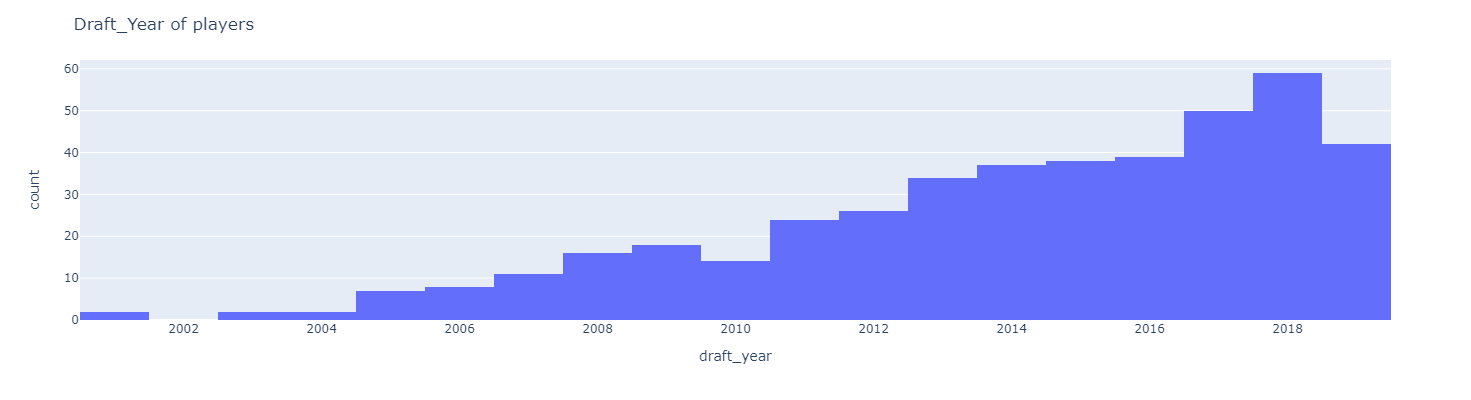

In [53]:
build_hist('draft_year')

The upper distribution is asymmetrical, but compared to others, it has a tail on the left.
This graph shows that as the years go on, more and more players are being drafted into the NBA

In [54]:
test_on_norm(df['draft_year'])

p-value:1.0510532923877881e-08.
The null hypothesis can be rejected


### Draft round

Let's create a pie chart to determine which draft round is most common

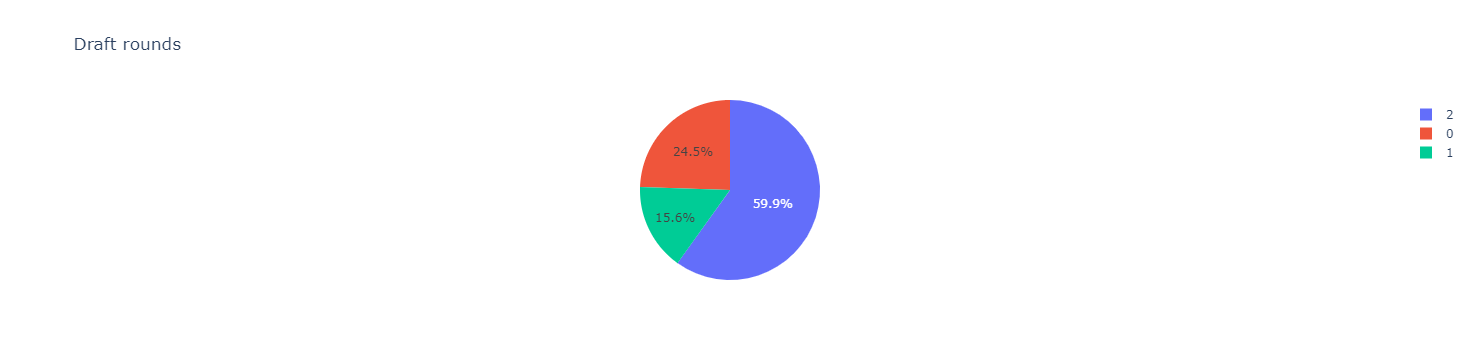

In [55]:
names = df['draft_round'].unique()

draft0 = df[df['draft_round'] == 0].shape[0] / df.shape[0]
draft1 = df[df['draft_round'] == 1].shape[0] / df.shape[0]
draft2 = df[df['draft_round'] == 2].shape[0] / df.shape[0]

draft_round = pd.DataFrame({'values': [draft0, draft1, draft2], 'names': names})

fig = px.pie(draft_round, values='values', names='names', title='Draft rounds')
fig.show()

We can see that most players in our data was drafted in the second round. Keep in mind that a draft value of 0 means that the player was undrafted. A player drafted in the first round seems to be the rarest

### Draft peak

Now we examine the draft peak of players

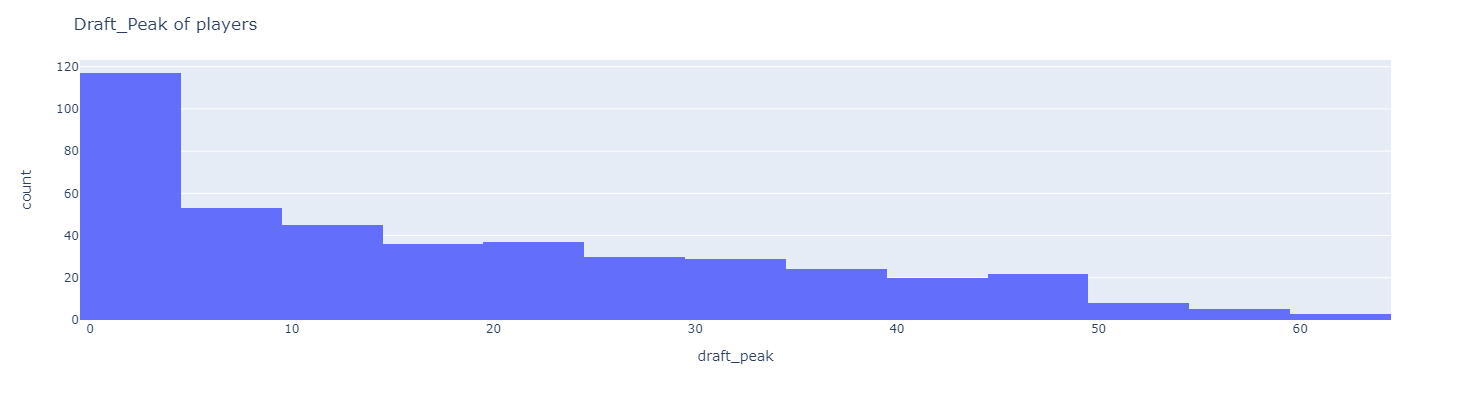

In [56]:
build_hist("draft_peak")

It can be seen that the distribution is asymmetric with a long right tail

In [57]:
test_on_norm(df['draft_peak'])

p-value:4.3900895285258016e-10.
The null hypothesis can be rejected


### College

Let's examine all the colleges from which the players in our data attended. This also includes players who did not attend

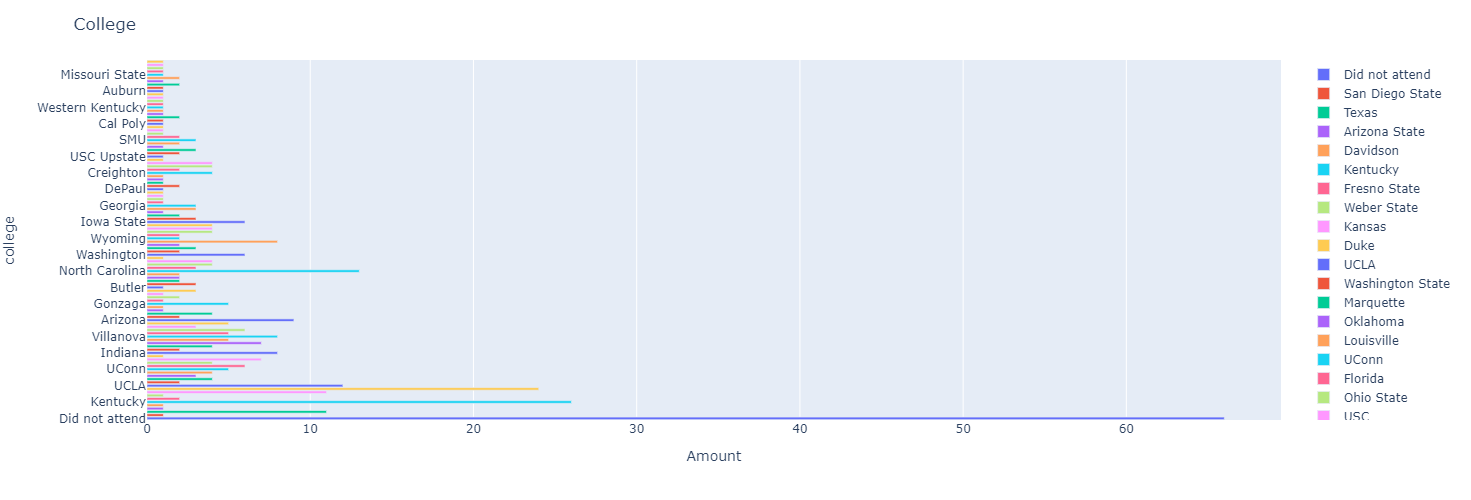

In [58]:
freq = build_bar("college")

The graph above shows that most players in our data actually did not attend a university or college. From those who did attend, however, Duke and Kentucky stand out as being the most popular

In [59]:
norm_res = stats.normaltest(freq)
print(f'p-value: {norm_res[1]}.')

p-value: 2.869386604532939e-40.


*-----------------------------------------------------------------------------------------------------------------------------------------------------------------------*

The previous analysis gave us knowledge about the individual attributes of a NBA player. We were able to graph and visualize the distribution of each features, the mean and median values, as well as the direction of the asymmetry in each feature(the tails). After examing each column's data individually, I will now visualize each column's data and it's correlation with other values

### Attribute interaction research

Before beginning our analysis, let us drop the full name and version columns as they are not important to our research

In [60]:
df = df.drop(columns=['full_name', 'version'])

df.head()

rating  jersey                  team position  height  weight    salary  \
0      97      23    Los Angeles Lakers        F    2.06   113.4  37436858   
1      97       2  Los Angeles Clippers        F    2.01   102.1  32742000   
2      96      34       Milwaukee Bucks      F-G    2.11   109.8  25842697   
3      96       7         Brooklyn Nets        F    2.08   104.3  37199000   
4      96      13       Houston Rockets        G    1.96    99.8  38199000   

  country  draft_year  draft_round  draft_peak          college  age  
0     USA        2003            1           1   Did not attend   37  
1     USA        2011            1          15  San Diego State   30  
2  Greece        2013            1          15   Did not attend   27  
3     USA        2007            1           2            Texas   33  
4     USA        2009            1           3    Arizona State   32

We determine the Pearson correlation of our numerical attributes.

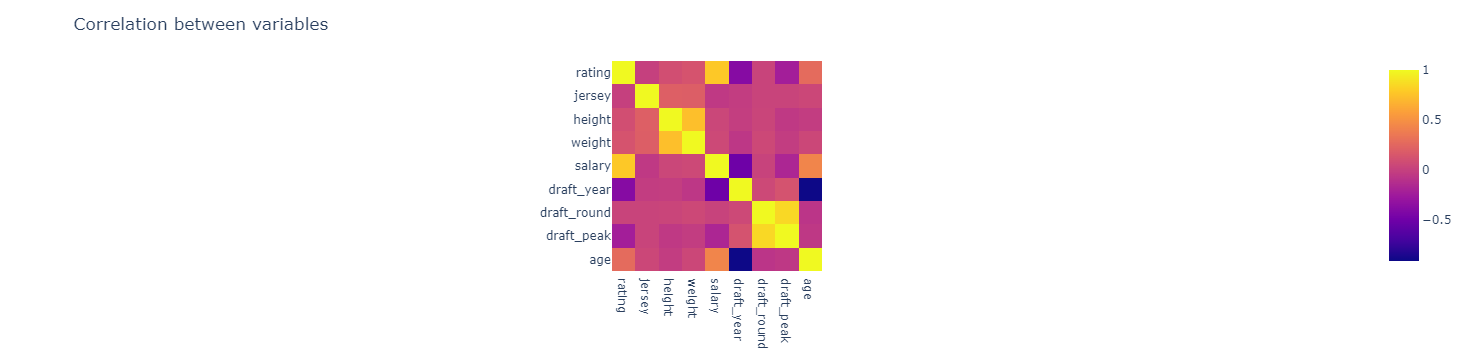

In [61]:
corr = df.corr()

fig = px.imshow(corr)
fig.update_layout(title = "Correlation between variables")
fig.show()

Let us take some time to examine the relationships portrayed in this heatmap:

Firstly, we can confirm the strong positive relationship between a player's salary and their rating.

There is also an obvious strong positive relationship between a player's height and weight.

The jersey attribute could have also been removed from this analysis as it seems that it does not correlate with any other attribute

There is also a relationship between a player's age as well as their salary and rating which is very interesting. This relationship will be examined further later on in our analyses.

An obvious strong negative relationship exists between a player's age and their draft year.

There is also a strong relationship between the draft round and the draft peak
    


In [62]:
df['rating'].describe()

count    429.000000
mean      76.372960
std        5.657748
min       67.000000
25%       72.000000
50%       75.000000
75%       79.000000
max       97.000000
Name: rating, dtype: float64

Let's divide our players into three categories: with a rating of up to 72, from 72 to 80 and more than 80. Then we compare the average salary between them.

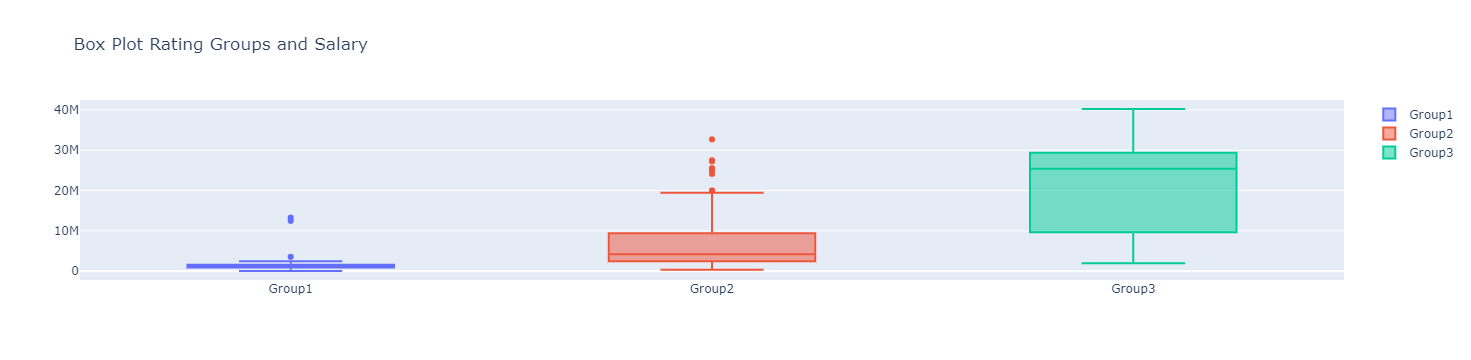

In [63]:
group1 = df[df['rating'] < 72]['salary'].values

a = df['rating'] >= 72
b = df['rating'] <= 80
group2 = df[a.values & b.values]['salary'].values

group3 = df[df['rating'] > 80]['salary'].values

fig = go.Figure()
fig.add_trace(go.Box(y=group1, name="Group1"))
fig.add_trace(go.Box(y=group2, name="Group2"))
fig.add_trace(go.Box(y=group3, name="Group3"))

fig.update_layout(title_text="Box Plot Rating Groups and Salary")
fig.show()

In [64]:
pd.options.mode.chained_assignment = None  # default='warn'
def convert2group(column):
    if column < 72:
        return 'group1'
    elif column > 80:
        return 'group3'
    else:
        return 'group2'

In [65]:
df_rate_sal = df[['rating', 'salary']]

df_rate_sal['rating'] = df_rate_sal['rating'].apply(convert2group)

df_rate_sal.head()

rating    salary
0  group3  37436858
1  group3  32742000
2  group3  25842697
3  group3  37199000
4  group3  38199000

 We have confirmed that the player's rating affects the level of wages as all players in group 3 (those who have a rating of 80 or higher) boast higher salaries than all other players in the other groups

Now let us compare age and salary

In [66]:
df['age'].describe()

count    429.000000
mean      27.825175
std        4.115133
min       21.000000
25%       25.000000
50%       27.000000
75%       31.000000
max       41.000000
Name: age, dtype: float64

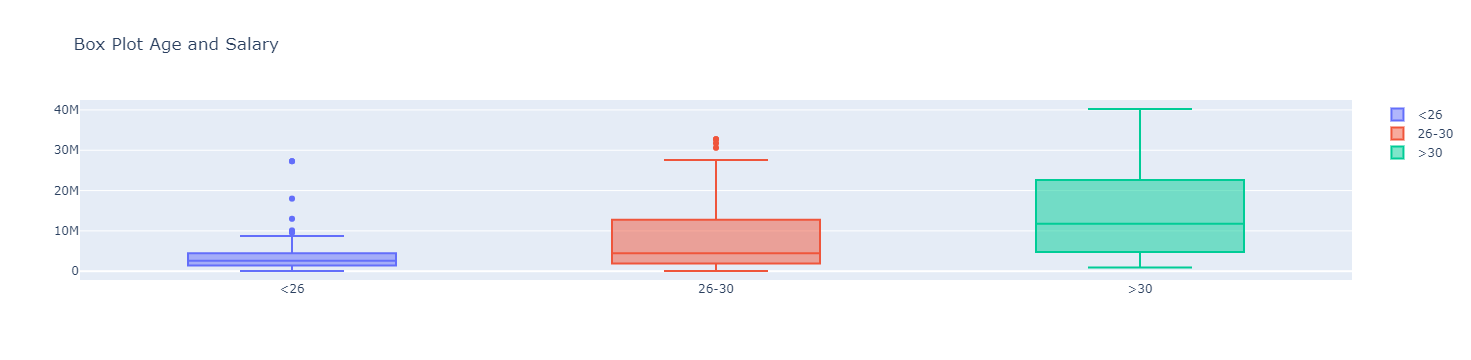

In [67]:
group1 = df[df['age'] < 26]['salary'].values

a = df['age'] >= 26
b = df['age'] <= 30
group2 = df[a.values & b.values]['salary'].values

group3 = df[df['age'] > 30]['salary'].values

fig = go.Figure()
fig.add_trace(go.Box(y=group1, name="<26"))
fig.add_trace(go.Box(y=group2, name="26-30"))
fig.add_trace(go.Box(y=group3, name=">30"))

fig.update_layout(title_text="Box Plot Age and Salary")
fig.show()

In [68]:
df_age_sal = df[['age', 'salary']]

def convert2group(item):
    if item < 25:
        return 'group1'
    elif item > 30:
        return 'group3'
    else:
        return 'group2'

df_age_sal['age'] = df_age_sal['age'].apply(convert2group)
df_age_sal.head()

age    salary
0  group3  37436858
1  group2  32742000
2  group2  25842697
3  group3  37199000
4  group3  38199000

It can be seen that age does a play a factor on salary as the youngest players obtain the smallest salaries when compared to their older teammates

Now we compare draft year and age

In [69]:
df['draft_year'].describe()

count     429.000000
mean     2014.093240
std         3.937678
min      2001.000000
25%      2012.000000
50%      2015.000000
75%      2017.000000
max      2019.000000
Name: draft_year, dtype: float64

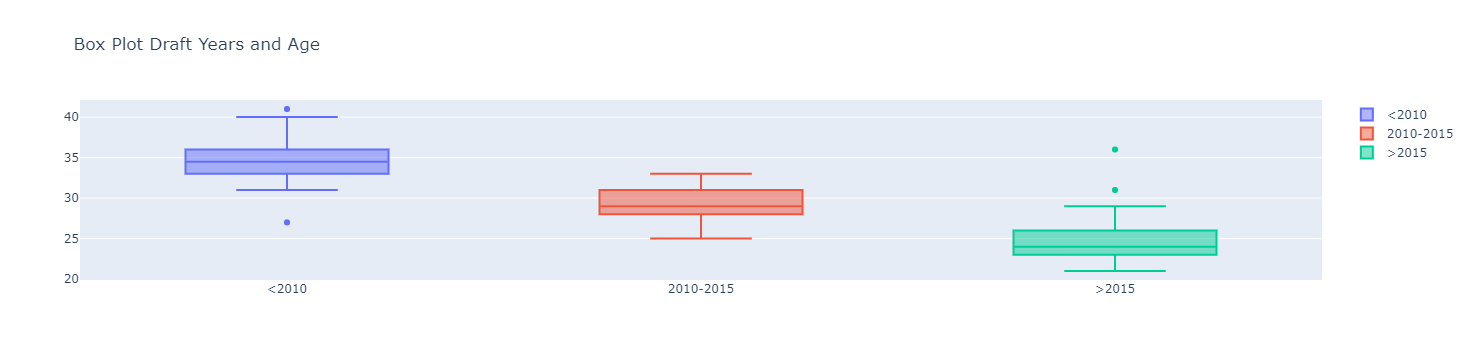

In [70]:
group1 = df[df['draft_year'] < 2010]['age'].values

a = df['draft_year'] >= 2010
b = df['draft_year'] <= 2015
group2 = df[a.values & b.values]['age'].values

group3 = df[df['draft_year'] > 2015]['age'].values

fig = go.Figure()
fig.add_trace(go.Box(y=group1, name="<2010"))
fig.add_trace(go.Box(y=group2, name="2010-2015"))
fig.add_trace(go.Box(y=group3, name=">2015"))

fig.update_layout(title_text="Box Plot Draft Years and Age")
fig.show()

The graph shows that the median differs between groups. To clarify, we will conduct more statistical analyzes.

In [71]:
df_draft_year_age = df[['draft_year', 'age']]

def convert2group(item):
    if item < 2010:
        return 'group1'
    elif item > 2015:
        return 'group3'
    else:
        return 'group2'

df_draft_year_age['draft_year'] = df_draft_year_age['draft_year'].apply(convert2group)
df_draft_year_age.head()

draft_year  age
0     group1   37
1     group2   30
2     group2   27
3     group1   33
4     group1   32

Through a quick analysis, we can see that the amount of younger players being drafted has grown as time goes on

Now we check the correlation between age and rating

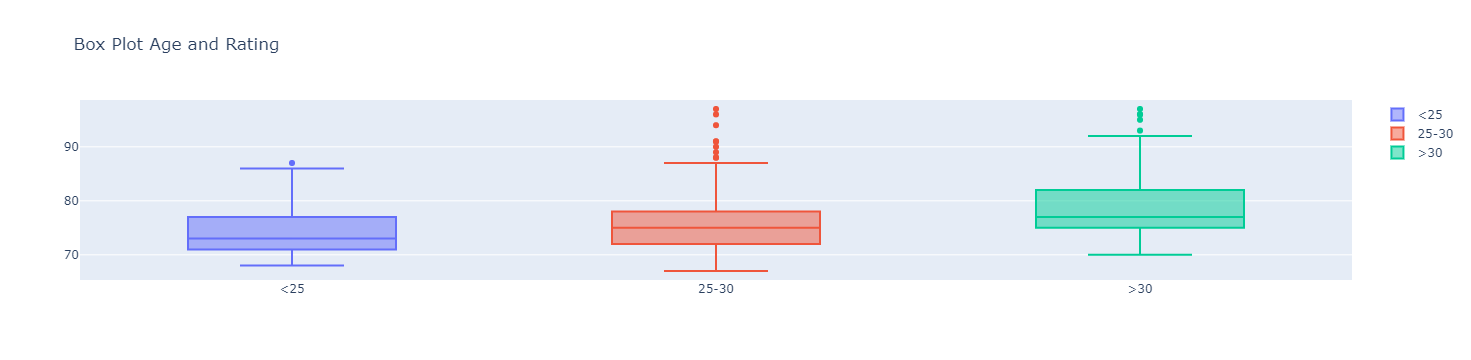

In [72]:
group1 = df[df['age'] < 25]['rating'].values

a = df['age'] >= 25
b = df['age'] <= 30
group2 = df[a.values & b.values]['rating'].values

group3 = df[df['age'] > 30]['rating'].values

fig = go.Figure()
fig.add_trace(go.Box(y=group1, name="<25"))
fig.add_trace(go.Box(y=group2, name="25-30"))
fig.add_trace(go.Box(y=group3, name=">30"))

fig.update_layout(title_text="Box Plot Age and Rating")
fig.show()

In [73]:
df_age_rat = df[['age', 'rating']]

def convert2group(item):
    if item < 25:
        return 'group1'
    elif item > 30:
        return 'group3'
    else:
        return 'group2'

df_age_rat['age'] = df_age_rat['age'].apply(convert2group)
df_age_rat.head()

age  rating
0  group3      97
1  group2      97
2  group2      96
3  group3      96
4  group3      96

We can see that older players do tend to have higher ratings which allows us to say that a player's rating does correlate with the player's age.
Next we examine the relationship between country, team and position on the target, as well as age.

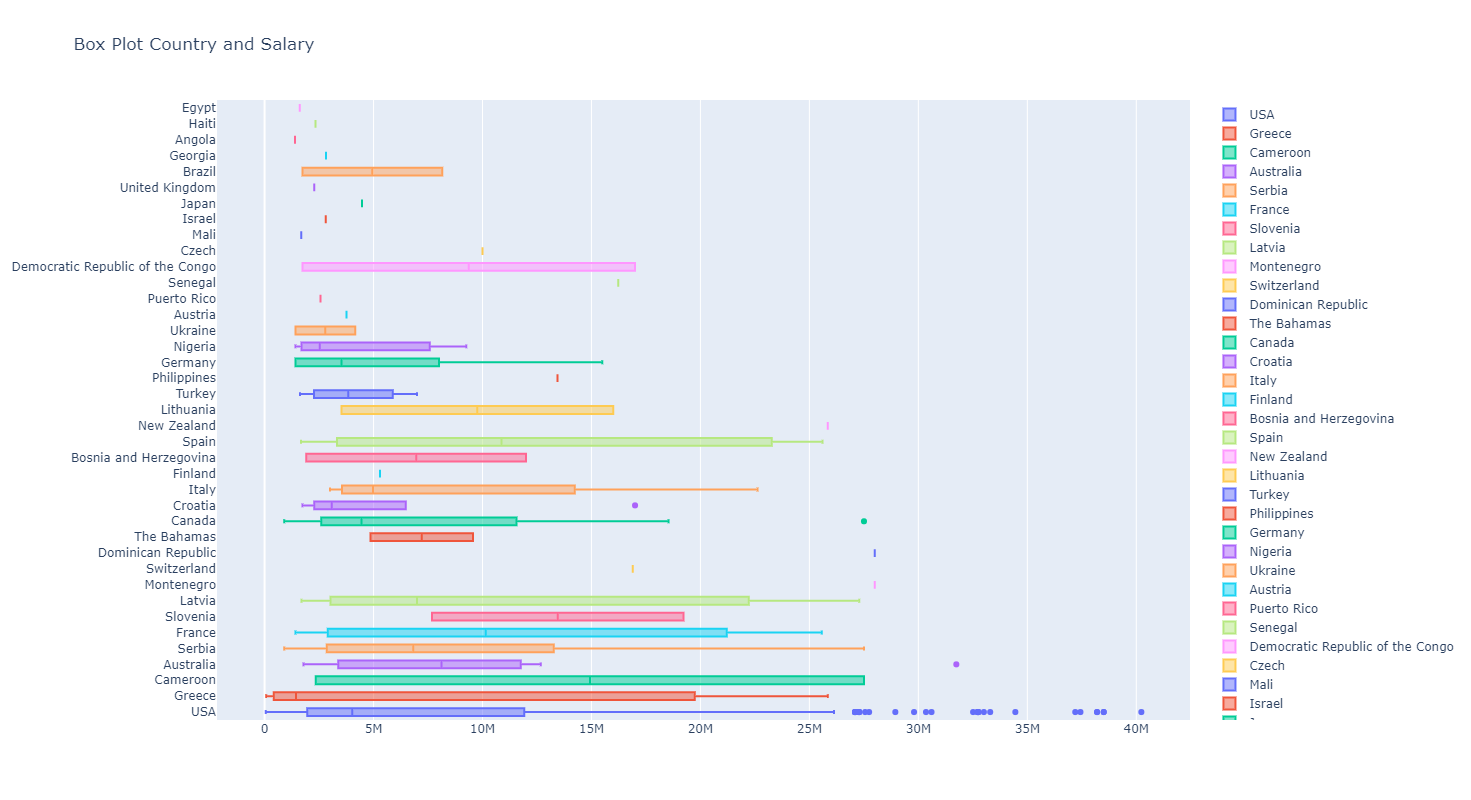

In [74]:
fig = go.Figure()

countries = df['country'].unique()

for country in countries:
    fig.add_trace(go.Box(x=df[df['country'] == country]['salary'], name=f"{country}"))

fig.update_layout(title_text="Box Plot Country and Salary", width=1000, height=800)
fig.update_traces(orientation='h')
fig.show()

Through the examination of the box plot graph, we can determine there is no correlation between country and salary

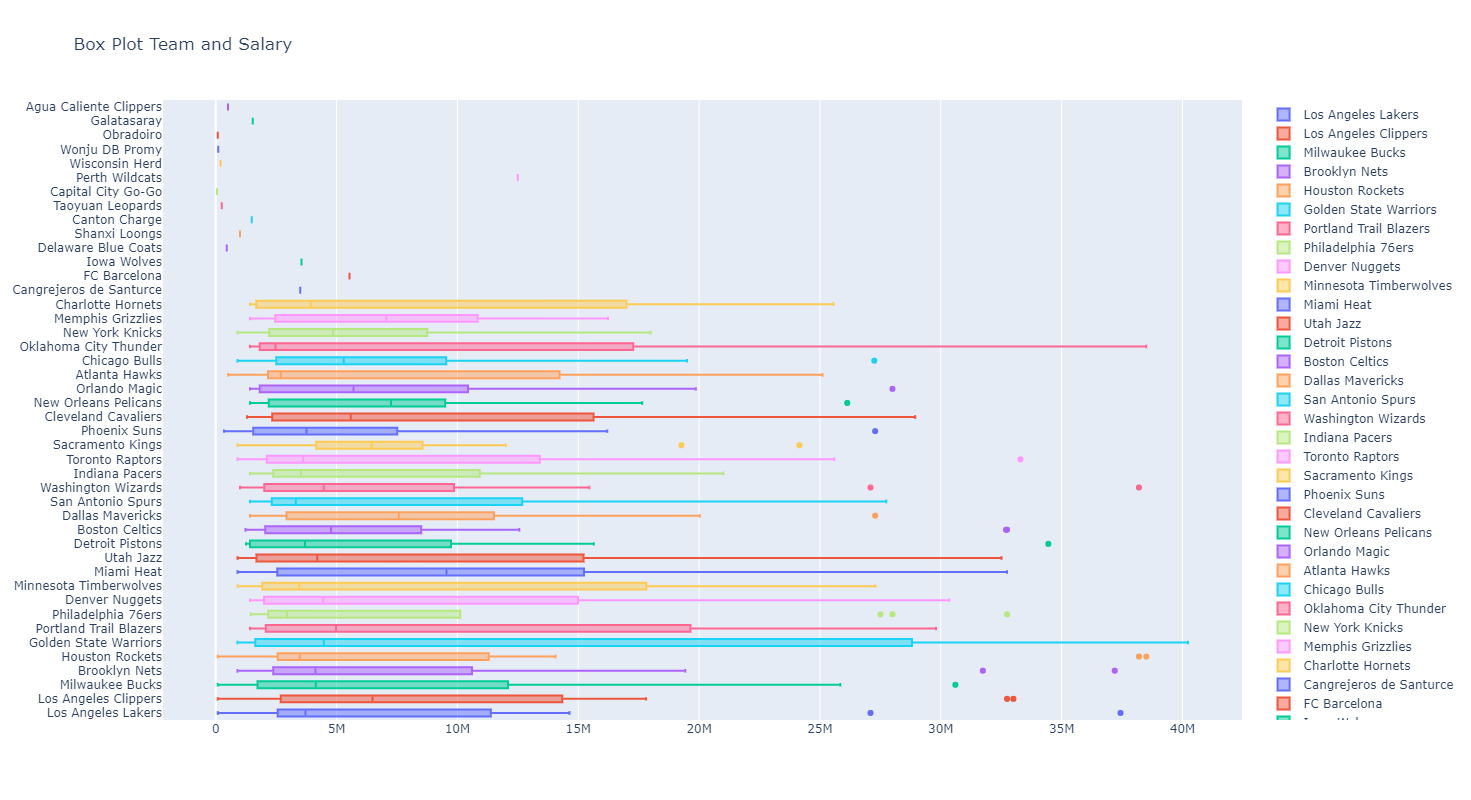

In [75]:
fig = go.Figure()

teams = df['team'].unique()

for team in teams:
    fig.add_trace(go.Box(x=df[df['team'] == team]['salary'], name=f"{team}"))

fig.update_layout(title_text="Box Plot Team and Salary", width=1000, height=800)
fig.update_traces(orientation='h')
fig.show()

The graph above also shows that although the median salaries may vary between players, the amounts are about the same.

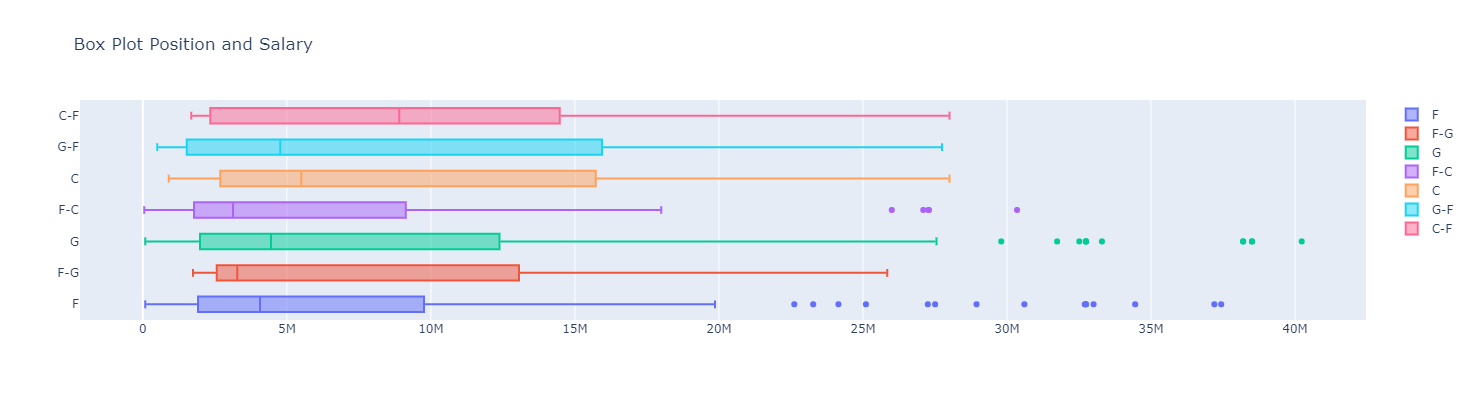

In [76]:
fig = go.Figure()

positions = df['position'].unique()

for position in positions:
    fig.add_trace(go.Box(x=df[df['position'] == position]['salary'], name=f"{position}"))

fig.update_layout(title_text="Box Plot Position and Salary", width=600, height=400)
fig.update_traces(orientation='h')
fig.show()

The graph above shows that although position in the team does not necessarily affect the level of wages, there are positions with more outlier salaries than others

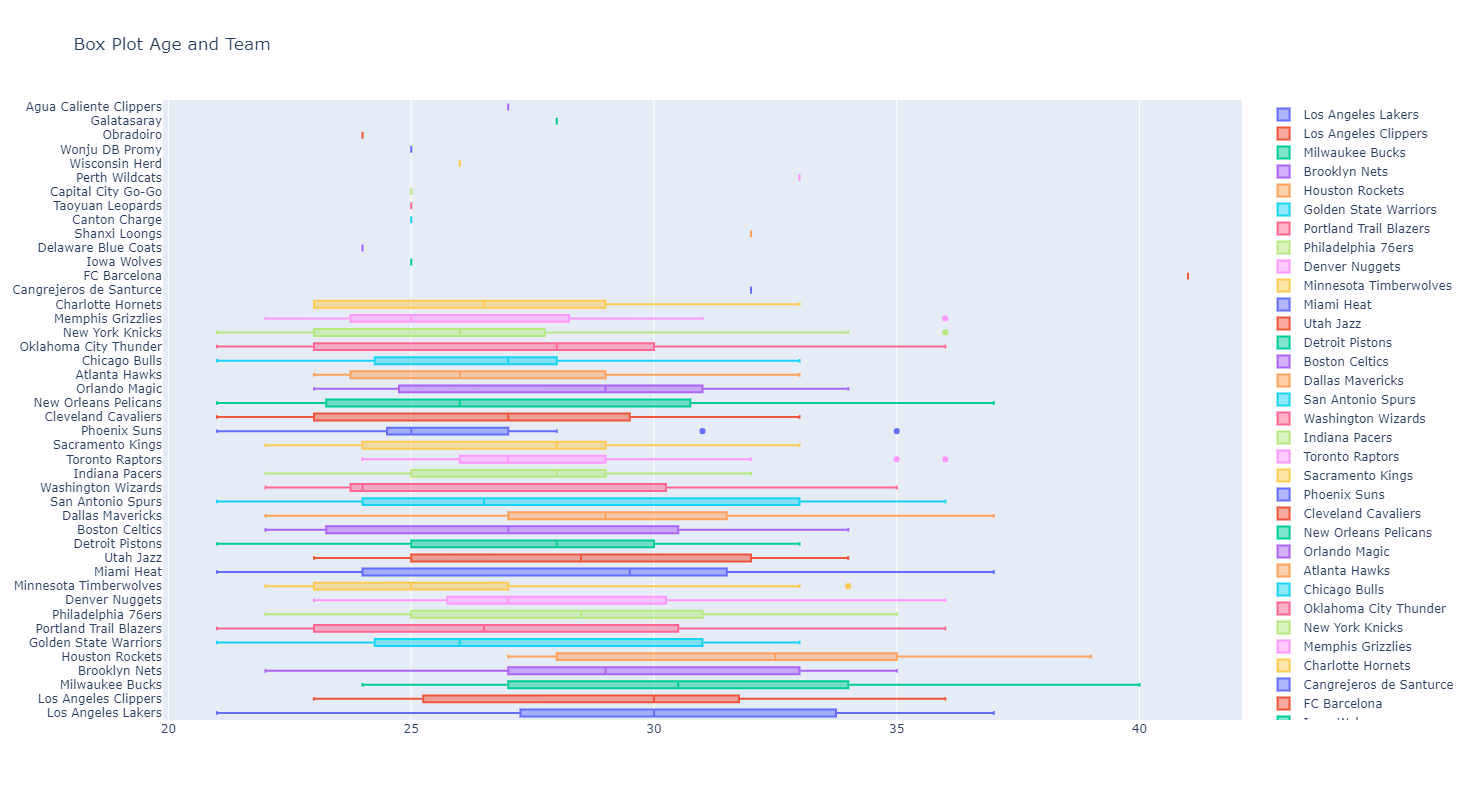

In [77]:
fig = go.Figure()

teams = df['team'].unique()

for team in teams:
    fig.add_trace(go.Box(x=df[df['team'] == team]['age'], name=f"{team}"))

fig.update_layout(title_text="Box Plot Age and Team", width=1000, height=800)
fig.update_traces(orientation='h')
fig.show()

Although there is no direct correlation between the age of a player and the team they're on, it is interesting to see which teams contain mostly young players. These teams are generally referred to as rebuild teams as they recruit new prospects that will gain experience and become better overtime. This is opposite to teams with mostly older players as these teams recruit veterans of the game in hopes of contending for a title with players who have already gained experience and improved

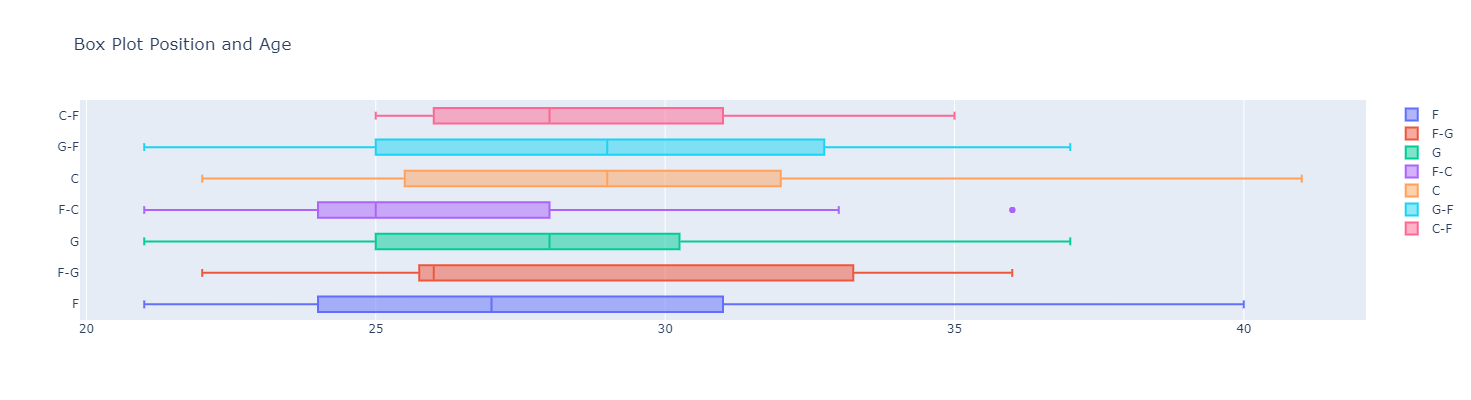

In [78]:
fig = go.Figure()

positions = df['position'].unique()

for position in positions:
    fig.add_trace(go.Box(x=df[df['position'] == position]['age'], name=f"{position}"))

fig.update_layout(title_text="Box Plot Position and Age", width=600, height=400)
fig.update_traces(orientation='h')
fig.show()

You can also see there is no correlation between age and position.

Now to clearly examine the amount of multicollinearity in the dataset, we calculate the Variance Inflation Factor (VIF). Within a regression model variable, this is equal to the ratio of the overall model variance to the variance of a model that includes only the single independent variable

In [79]:
from sklearn.linear_model import LinearRegression
def calculate_vif(df, features):    
    vif, tolerance = {}, {}

    for feature in features:
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        tolerance[feature] = 1 - r2
        vif[feature] = 1/(tolerance[feature])

    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})

In [80]:
allow_col = ['rating', 'jersey', 'height', 'weight', 'draft_peak', 'age', 'draft_year', 'draft_round']

calculate_vif(df, allow_col)

VIF  Tolerance
rating       1.516265   0.659515
jersey       1.052732   0.949909
height       2.222035   0.450038
weight       2.213652   0.451742
draft_peak   5.147858   0.194256
age          7.572440   0.132058
draft_year   7.994971   0.125079
draft_round  4.890632   0.204473

Looking at the above table, we look at the VIF column. When reading the column, we check to see if the VIF is greater than 5. If it is greater than 5, then we can assume that there is a strong correlation of the attributes. With that being said, we can say that the age of the player has a strong correlation with the year of the player's draft, the round of the draft and the peak draft. This correlation makes sense since the NBA has become more tolerable with recruiting younger players into the NBA, recently going down to the age of 19 since the NBA players eligible to be recruited must be one season removed from high school.

With this being said, if we delete the draft year from our calculation, we can assume that there will be little to no collinearity 

In [81]:
calculate_vif(df, allow_col[:-2])

VIF  Tolerance
rating      1.153106   0.867223
jersey      1.051184   0.951308
height      2.206507   0.453205
weight      2.202486   0.454032
draft_peak  1.060138   0.943273
age         1.091656   0.916039